In [177]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from pydpmd.calc import run_binned, run_binned_ragged, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
import pandas as pd
import h5py
from mode_resources import *

In [243]:
root = '/home/mmccraw/dev/data/10-16-25/data-from-grace/rb-compression-diffusion-lower-temp'

remove_rattlers = True
critical_rattler_contact_count = 4
use_forces_for_rattler_check = True

calculate_hessian = False

dataset = {
    'nv': [],
    'mu': [],
    'phi_j': [],
    'pair_vertex_contacts': [],
    'z_p': [],
    'z_v': [],
    'mu_mean': [],
    'mu_std': [],
    'mu_dist': []
}

if calculate_hessian:
    dataset['vals'] = []
    dataset['vecs'] = []

for friction_root in tqdm(os.listdir(root)):
    i = 0
    while os.path.exists(data_path := os.path.join(root, friction_root, f'calculation_{i}')):
        i += 1
        data = load(data_path, location=['final', 'init'])
        data.calculate_mu_eff()

        if calculate_hessian:
            modes = np.load(os.path.join(data_path, 'modes.npz'), allow_pickle=True)
            if len(modes.keys()) == 0:
                modes = None
            else:
                modes = modes['arr_0'].item()

        for sid in range(data.n_systems()):
            if data.final.pe_total[sid] / data.system_size[sid] > 1e-15:
                continue
            pid_0 = data.system_offset[sid]
            pid_N = data.system_offset[sid + 1]
            N = data.system_size[sid]

            mask = np.all((data.final.pair_ids >= pid_0) & (data.final.pair_ids < pid_N), axis=1)
            pair_ids = data.final.pair_ids[mask]
            local_pair_ids = pair_ids - pid_0
            pair_vertex_contacts = data.final.pair_vertex_contacts[mask].copy()
            friction_dist = data.final.friction_coeff[mask].copy()

            if remove_rattlers:
                rattler_ids, non_rattler_ids = get_rigid_bumpy_rattlers(
                    data.final.pair_forces[mask].copy(),
                    local_pair_ids.copy(),
                    np.max(data.final.pair_vertex_contacts[mask].copy(), axis=1),
                    critical_rattler_contact_count,
                    check_forces=use_forces_for_rattler_check
                )
                non_rattler_pair_mask = np.isin(local_pair_ids[:, 0], non_rattler_ids) & np.isin(local_pair_ids[:, 1], non_rattler_ids)
                pair_vertex_contacts = pair_vertex_contacts[non_rattler_pair_mask]
                N = len(non_rattler_ids)
                friction_dist = friction_dist[non_rattler_pair_mask]
            
            dataset['phi_j'].append(data.final.packing_fraction[sid])
            dataset['mu'].append(data.mu_eff[data.system_offset[:-1]][sid])
            dataset['nv'].append(data.n_vertices_per_particle[data.system_offset[:-1]][sid])
            dataset['pair_vertex_contacts'].append(pair_vertex_contacts[np.all(pair_vertex_contacts != 0, axis=1)])
            dataset['z_v'].append(np.sum(np.max(pair_vertex_contacts[np.all(pair_vertex_contacts != 0, axis=1)], axis=1)) /N)
            # dataset['z_v'].append(np.sum(pair_vertex_contacts[np.all(pair_vertex_contacts != 0, axis=1)][:, 0]) /N)
            dataset['z_p'].append(np.sum(np.all(pair_vertex_contacts != 0, axis=1)) / N)
            dataset['mu_mean'].append(np.mean(friction_dist[friction_dist > 0]))
            dataset['mu_std'].append(np.std(friction_dist[friction_dist > 0]))
            dataset['mu_dist'].append(friction_dist[friction_dist > 0])

            if calculate_hessian:
                if modes is None:
                    dataset['vals'].append(None)
                    dataset['vecs'].append(None)
                else:
                    if f'val_{i}' in modes.keys():
                        dataset['vals'].append(modes[f'val_{i}'])
                        dataset['vecs'].append(modes[f'val_{i}'])
                    else:
                        dataset['vals'].append(None)
                        dataset['vecs'].append(None)
            
dataset = pd.DataFrame(dataset, dtype=object)

unique_pair_types = np.unique(np.concatenate(dataset.pair_vertex_contacts.values), axis=0)
pair_types = np.sort(unique_pair_types, axis=1)
unique_pairs, inverse_ids = np.unique(pair_types, axis=0, return_inverse=True)

100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


There seems to be a switch at some critical $N_v~5$.  For $N_v<5$, the particles can only have 1-1 contacts.  For $5<N_v<8$, the particles can have 1-2 contacts at low densities and 1-1 contacts at high densities.  For $N_v>8$, the particles can only have 1-2 contacts.

Important note: the $N_v=3$ graph can be place to the right of the $N_v=6$ graph, making an X.  The two can then be placed to the right of the $N_v=10$ graph and so on...

/tmp/ipykernel_1052036/1613852878.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(phi_j, pair_counts, c=cmap(mu_norm(_mu)), marker=marker)


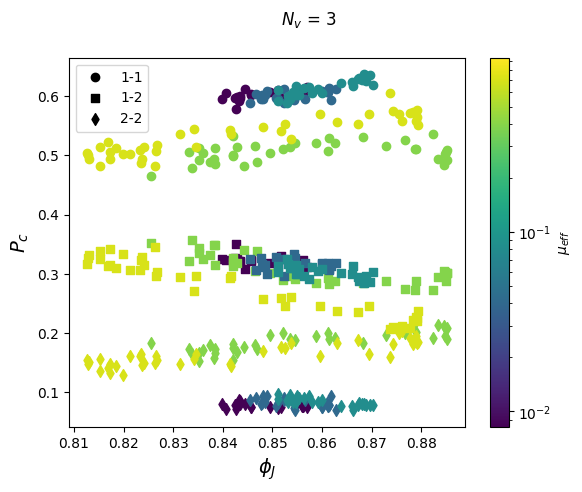

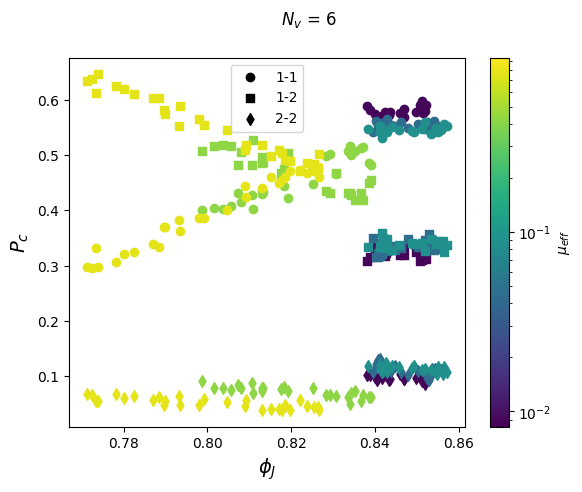

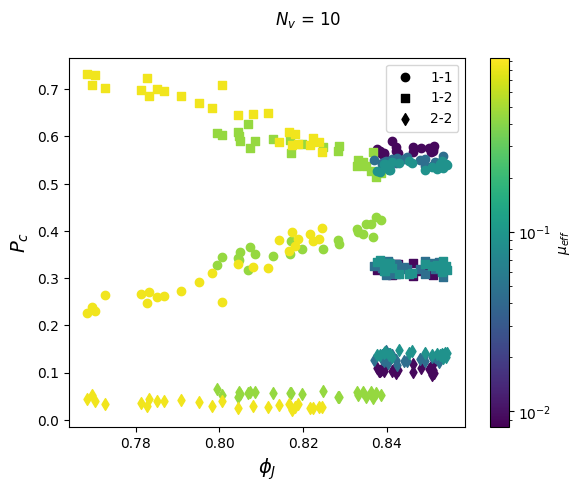

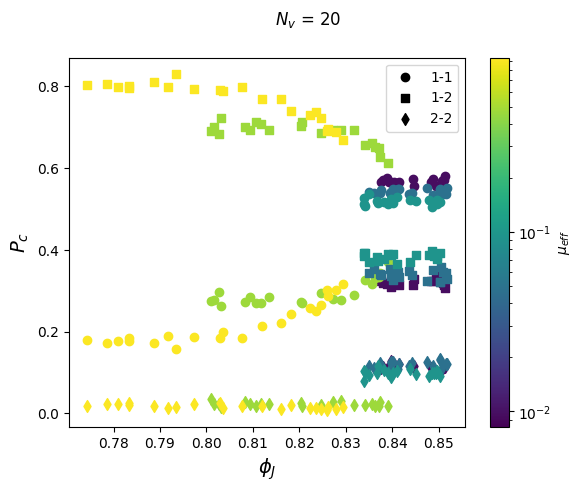

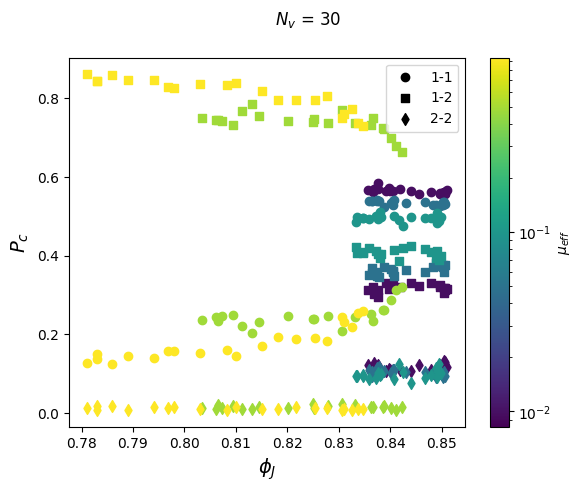

In [374]:
marker_styles = ['o', 's', 'd', '|', 'x', '>', 'D', 'p', '*', 'h', 'H', 'd', '_', 'd', '|', '_']
num_pair_types = 3

mu_norm = LogNorm(vmin=dataset.mu.min(), vmax=dataset.mu.max())
cmap = plt.cm.viridis

for _nv in dataset.nv.unique():
    for _mu in dataset.mu.unique():
        mask = (dataset.nv == _nv) & (dataset.mu == _mu)
        if not np.any(mask):
            continue
        for pair_id, marker in zip(unique_pairs[:num_pair_types], marker_styles):
            pair_counts = np.array([np.mean(np.all(np.sort(pairs, axis=1) == pair_id, axis=1)) for pairs in dataset[mask].pair_vertex_contacts.values])
            phi_j = dataset[mask].phi_j
            plt.scatter(phi_j, pair_counts, c=cmap(mu_norm(_mu)), marker=marker)
    for pair_id, marker in zip(unique_pairs[:num_pair_types], marker_styles):
        plt.scatter([], [], marker=marker, c='k', label=f'{pair_id[0]}-{pair_id[1]}')
    plt.legend()
    plt.xlabel(r'$\phi_J$', fontsize=14)
    plt.ylabel(r'$P_c$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(_nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(dataset.mu.unique().tolist())
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/contact-types/NV-{_nv}.png', dpi=600)
    plt.show()



We basically have a constant number of vertex contacts, just below the isostatic amount.  This is obvious as otherwise we wouldn't be jammed.  This means, we must have this isostatic contact number for all $\phi$.

However, the number of particle contacts is variable across $\phi$.  Basically, you can jam at a lower $\phi$ with fewer particle contacts.  To compensate, you need to have a larger number of high friction (i.e. 1-2 or 2-2) contacts to be stabilized.  This is why we see the lower $\phi$ jammed states starting with a larger number of high friction contacts and fewer overall particle contacts.  However, as $\phi$ increases, you gain particle contacts and lose the high friction contacts.

/tmp/ipykernel_1052036/2782130516.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(dataset[mask].phi_j, dataset[mask].z_v, c=cmap(mu_norm(_mu)))
/tmp/ipykernel_1052036/2782130516.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(dataset[mask].phi_j, dataset[mask].z_p, c=cmap(mu_norm(_mu)))


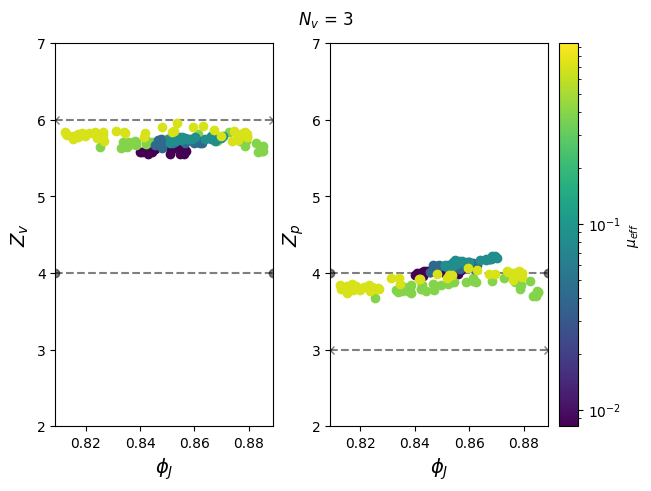

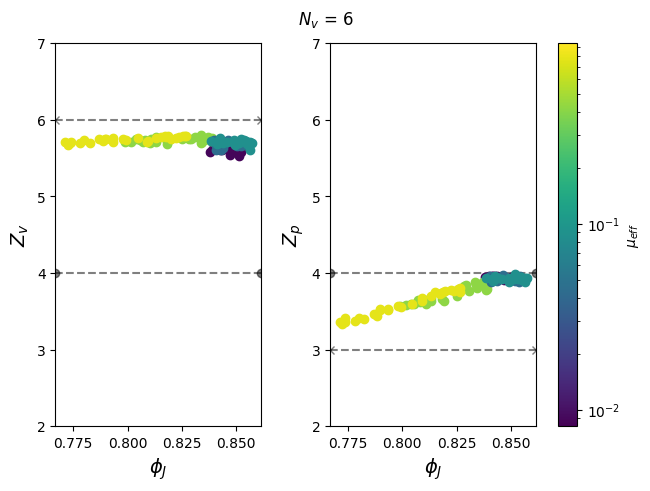

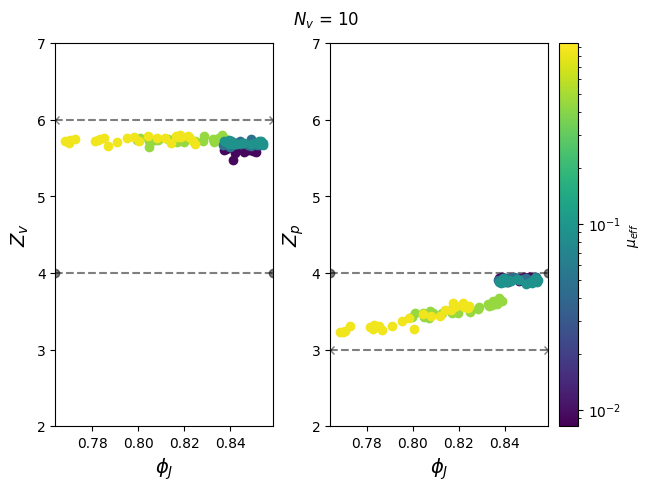

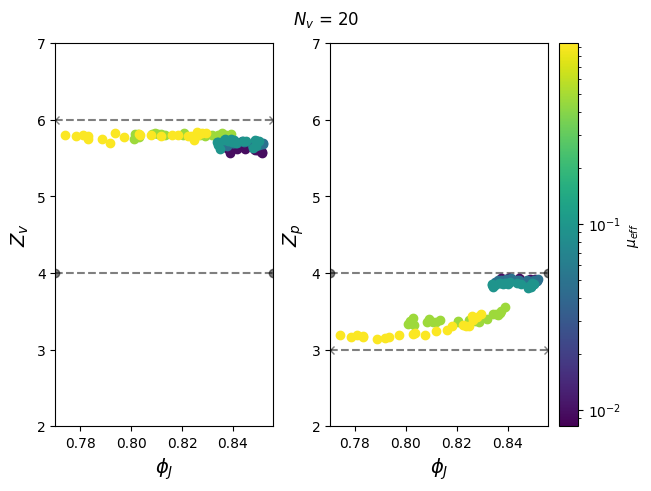

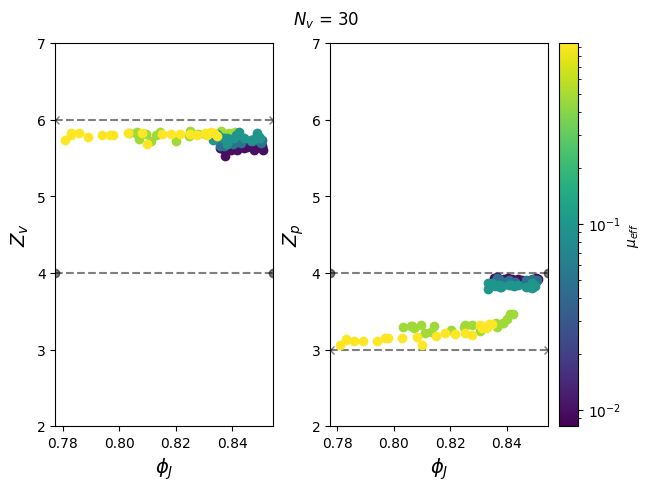

In [375]:
for _nv in dataset.nv.unique():
    fig, ax = plt.subplots(1, 2, constrained_layout=True, sharex=True)
    for _mu in dataset.mu.unique():
        mask = (dataset.nv == _nv) & (dataset.mu == _mu)
        if not np.any(mask):
            continue
        ax[0].scatter(dataset[mask].phi_j, dataset[mask].z_v, c=cmap(mu_norm(_mu)))
        ax[1].scatter(dataset[mask].phi_j, dataset[mask].z_p, c=cmap(mu_norm(_mu)))
    ax[0].axhline(6, linestyle='--', marker='x', color='k', alpha=0.5, zorder=0)
    ax[0].axhline(4, linestyle='--', marker='o', color='k', alpha=0.5, zorder=0)
    ax[1].axhline(3, linestyle='--', marker='x', color='k', alpha=0.5, zorder=0)
    ax[1].axhline(4, linestyle='--', marker='o', color='k', alpha=0.5, zorder=0)
    for a in ax:
        a.set_xlabel(r'$\phi_J$', fontsize=14)
        a.set_ylim(2, 7)
    ax[0].set_ylabel(r'$Z_v$', fontsize=14)
    ax[1].set_ylabel(r'$Z_p$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(_nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(dataset.mu.unique().tolist())
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/contact-counts/NV-{_nv}.png', dpi=600)
    plt.show()

Your friction is not what you think it is.

/tmp/ipykernel_1052036/1365289374.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(dataset[mask].phi_j, dataset[mask].mu_mean / _mu, c=cmap(mu_norm(_mu)))


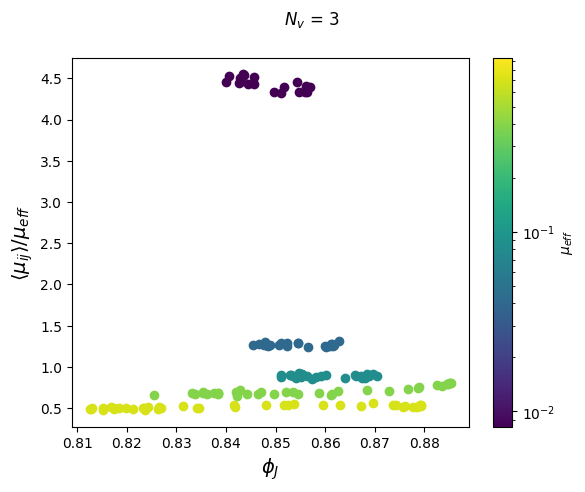

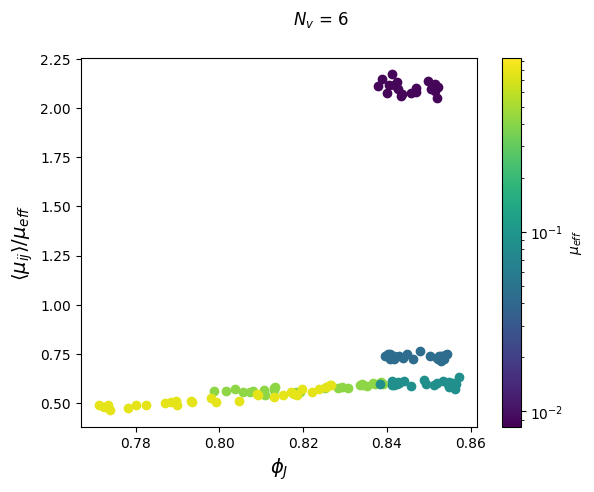

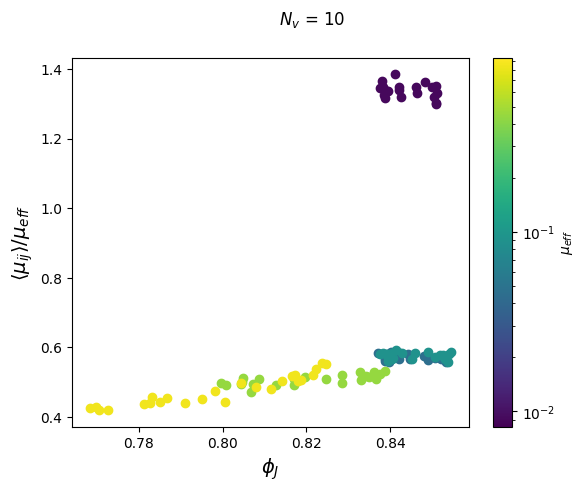

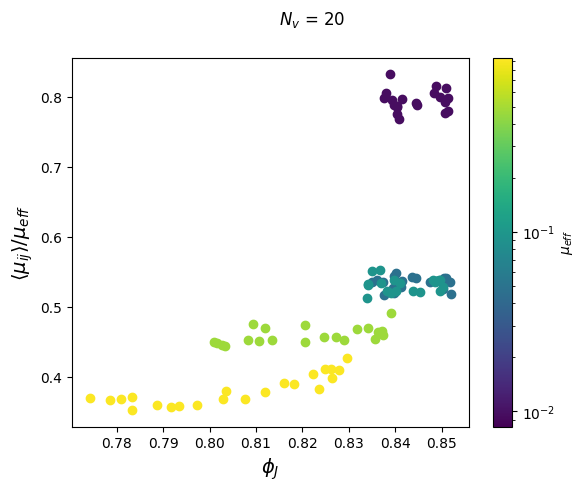

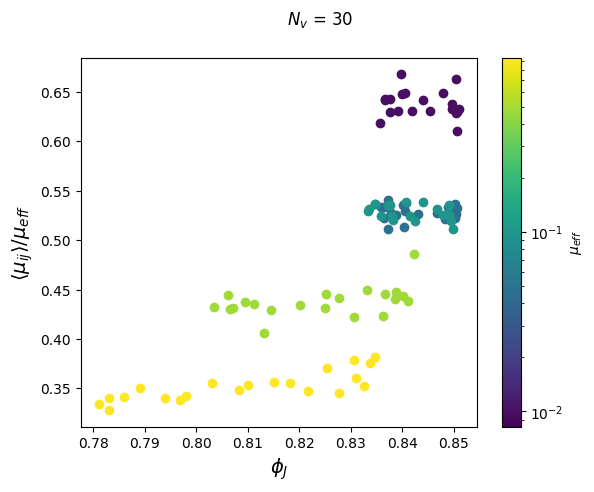

In [376]:
for _nv in dataset.nv.unique():
    for _mu in dataset.mu.unique():
        mask = (dataset.nv == _nv) & (dataset.mu == _mu)
        if not np.any(mask):
            continue
        plt.scatter(dataset[mask].phi_j, dataset[mask].mu_mean / _mu, c=cmap(mu_norm(_mu)))
    plt.xlabel(r'$\phi_J$', fontsize=14)
    plt.ylabel(r'$\langle \mu_{ij}\rangle / \mu_{eff}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(_nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(dataset.mu.unique().tolist())
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/mean-friction/NV-{_nv}.png', dpi=600)
    plt.show()

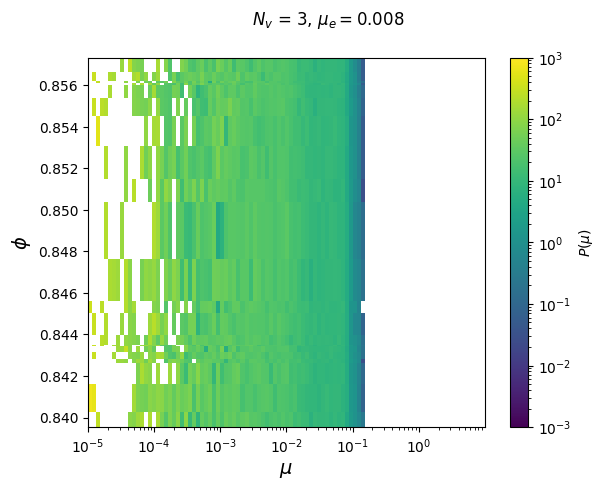

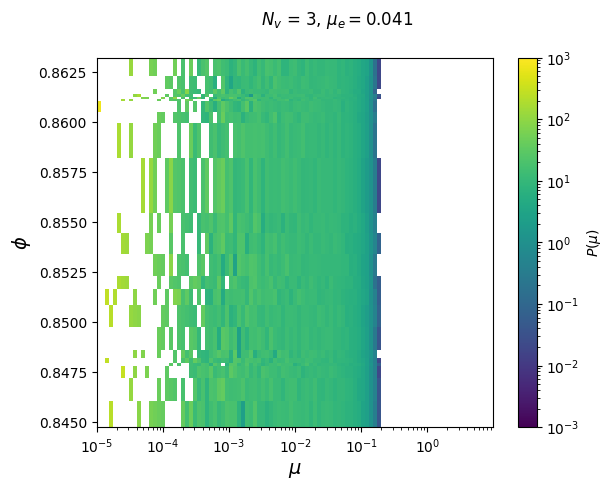

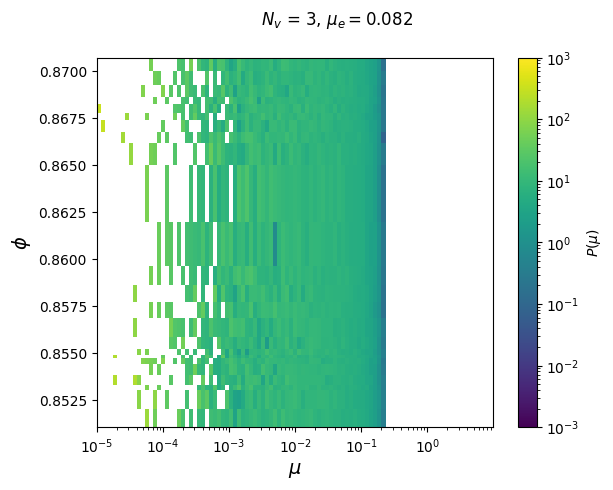

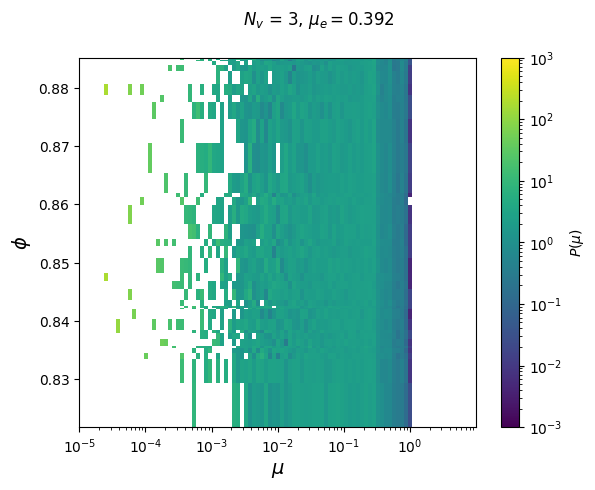

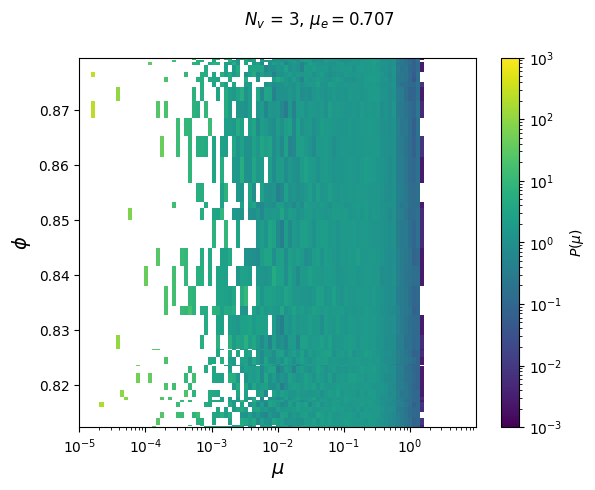

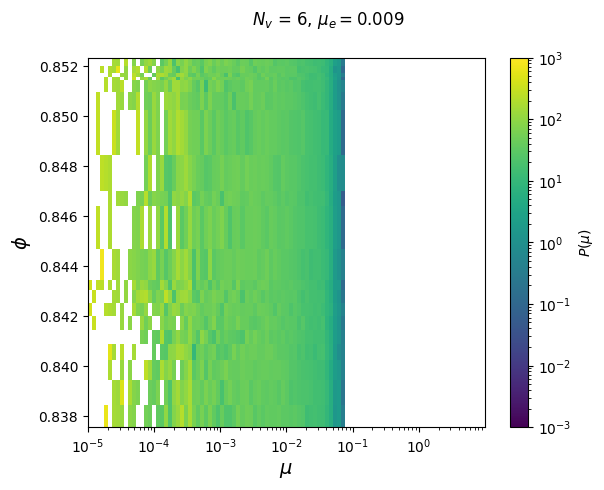

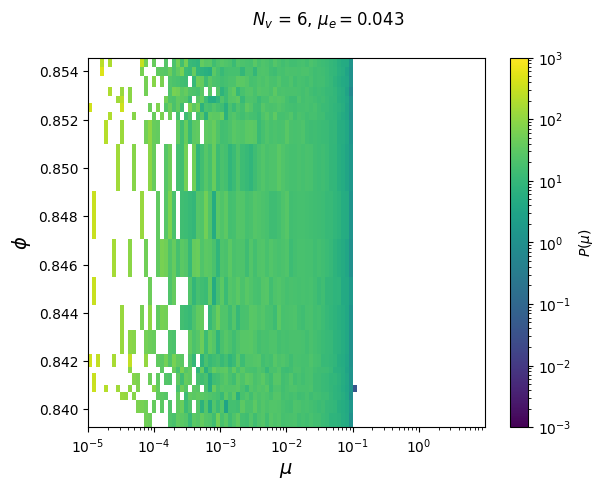

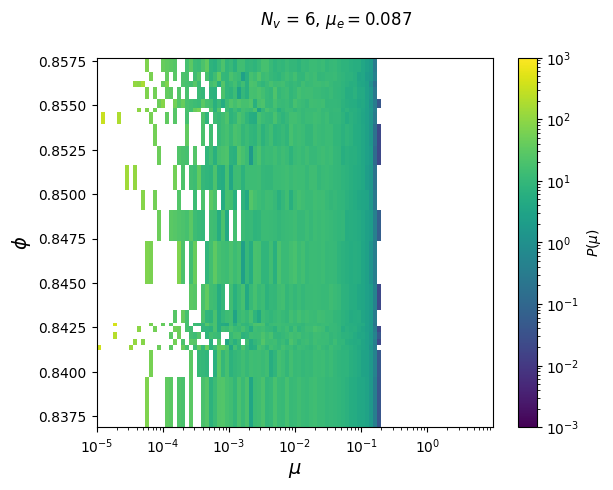

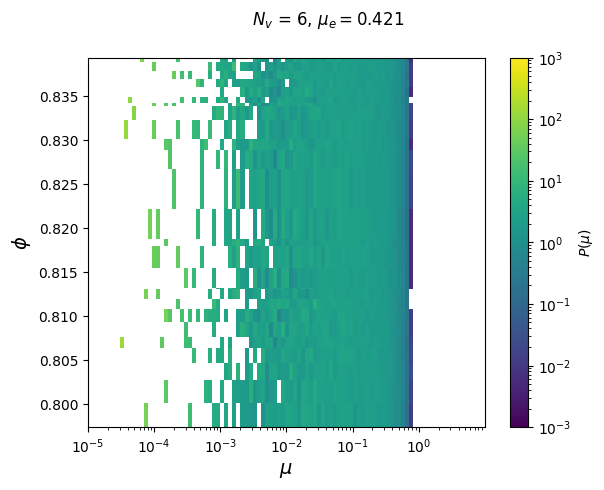

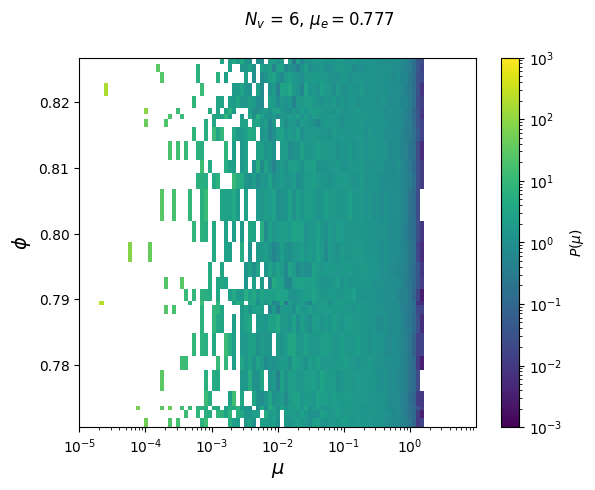

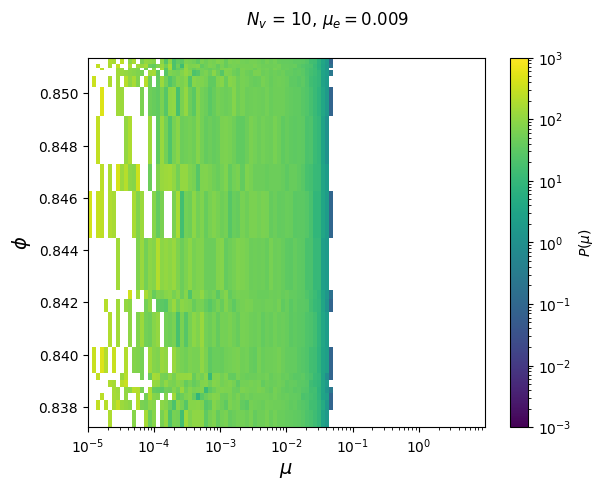

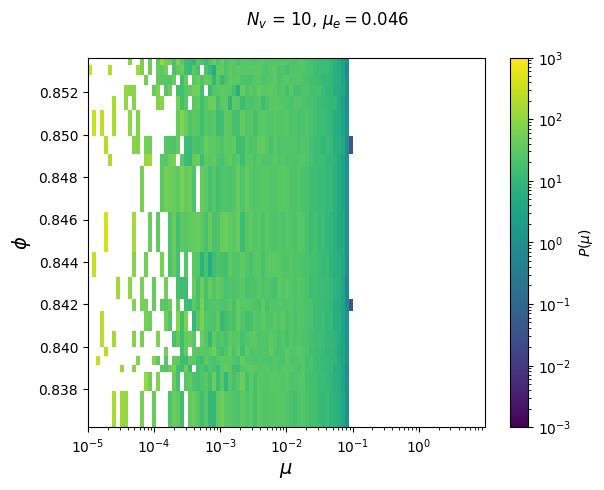

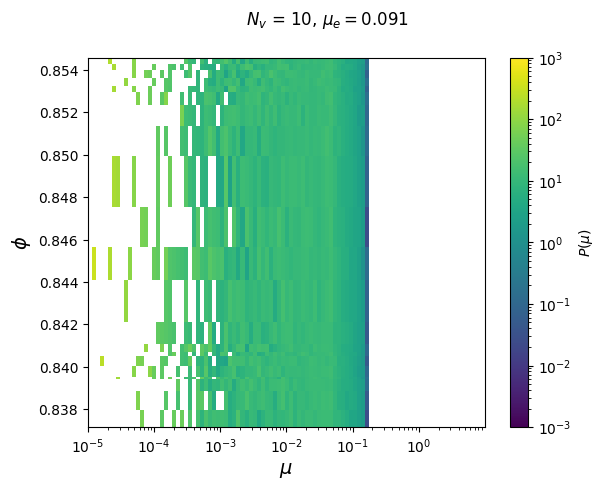

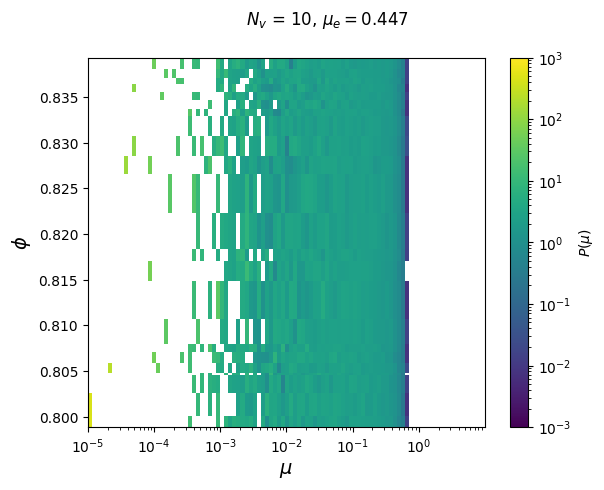

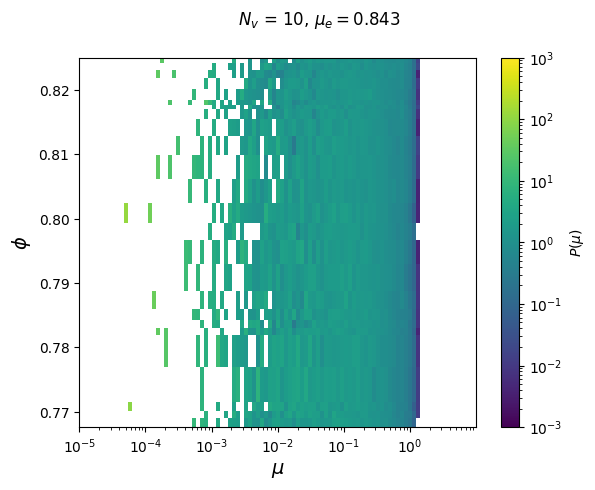

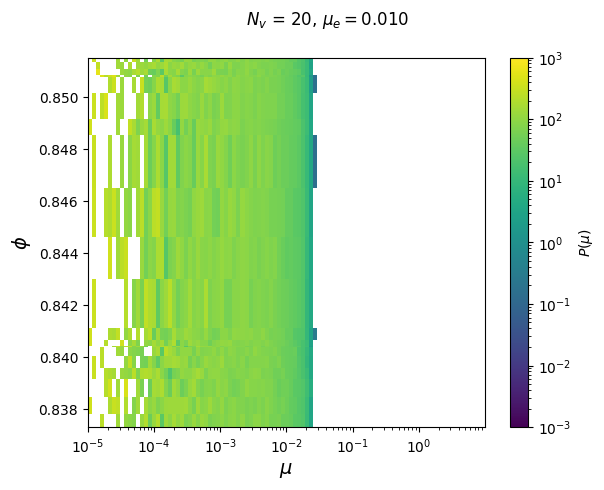

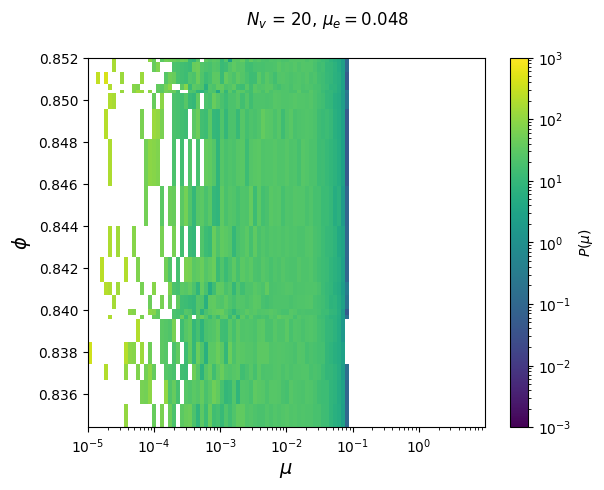

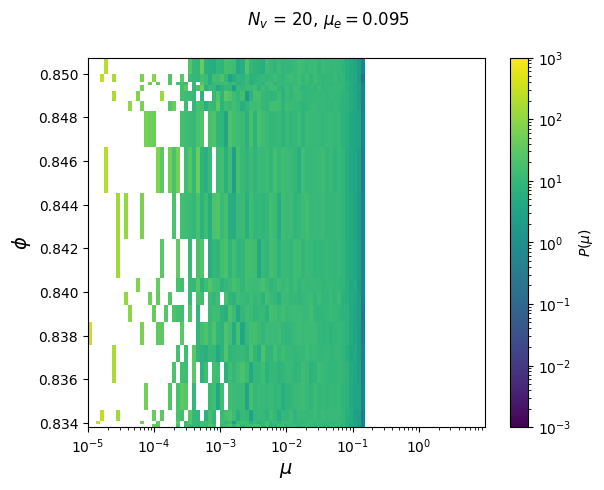

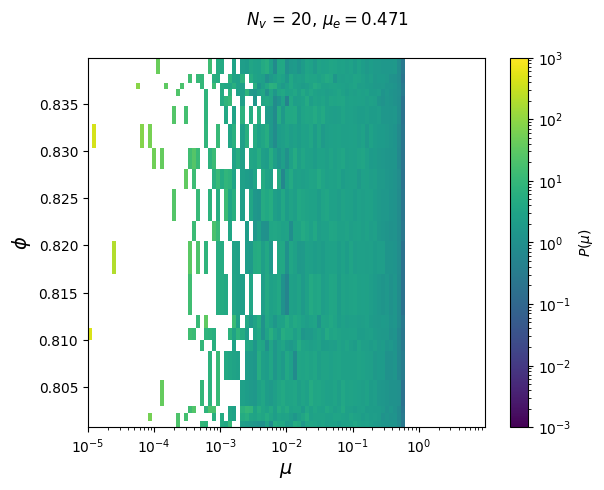

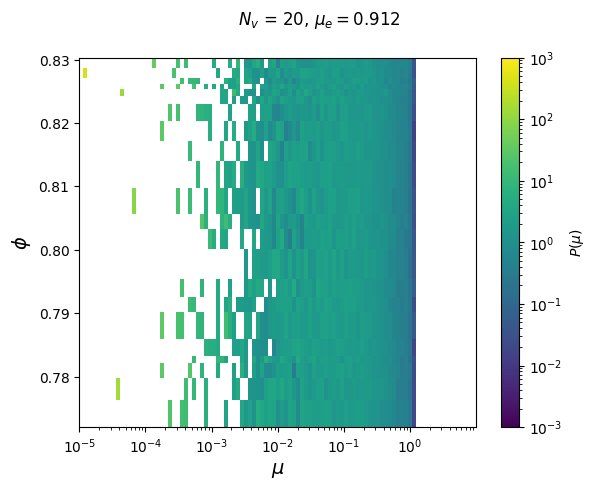

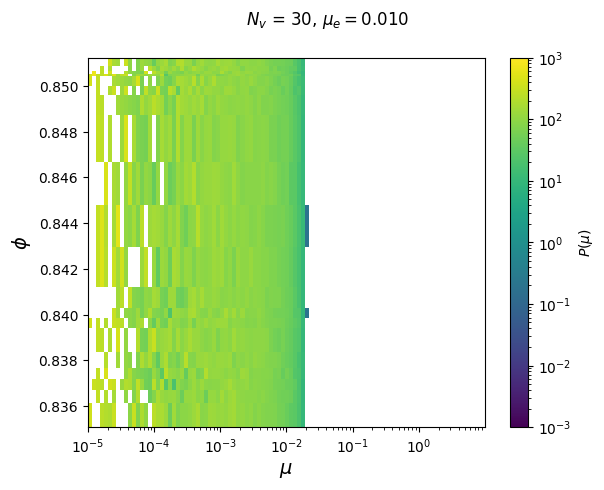

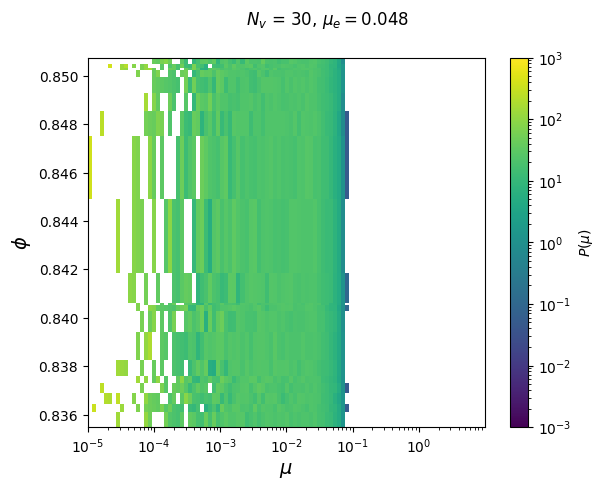

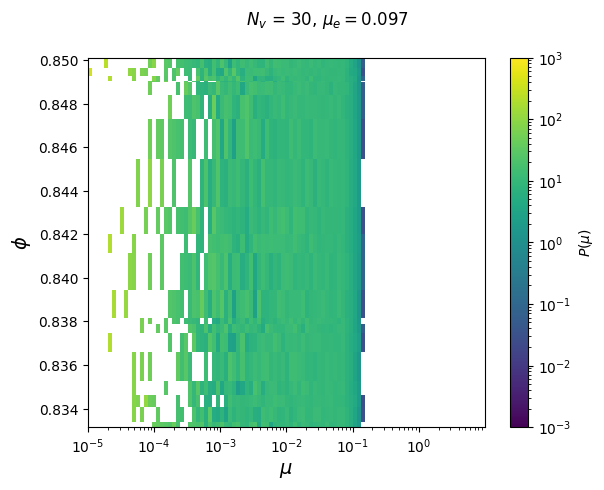

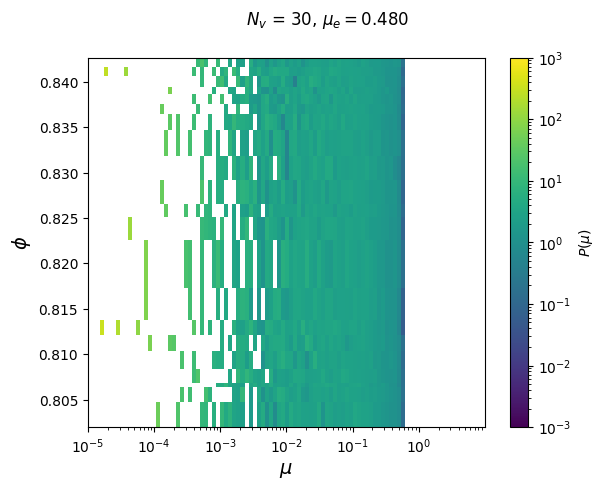

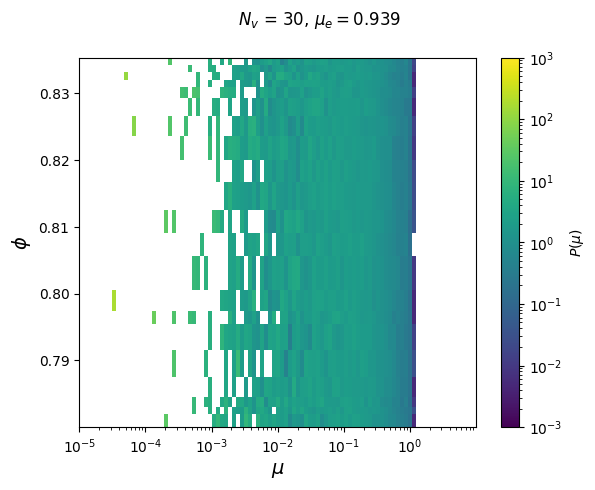

In [355]:
hist_norm = LogNorm(vmin=1e-3, vmax=1e3)
n_bins = 100

# mu_bin_edges = np.linspace(1e-5, 5, n_bins)
mu_bin_edges = np.logspace(-5, 1, n_bins)
mu_bins = (mu_bin_edges[1:] + mu_bin_edges[:-1]) / 2

for _nv in np.sort(dataset.nv.unique()):
    for _mu in np.sort(dataset.mu.unique()):
        mask = (dataset.nv == _nv) & (dataset.mu == _mu)
        if not np.any(mask):
            continue
        x = dataset[mask].phi_j.values
        y = dataset[mask].mu_dist.values
        order = np.argsort(x)
        x = x[order].astype(float)
        y = y[order]
        Y = np.array([np.histogram(y[i], mu_bin_edges, density=True)[0] for i in range(len(y))])

        fig, ax = plt.subplots()
        im = ax.pcolormesh(mu_bins, x, Y, shading='auto', norm=hist_norm)
        plt.colorbar(im, ax=ax, label=r'$P(\mu)$')
        plt.xscale('log')
        plt.xlabel(r'$\mu$', fontsize=14)
        plt.ylabel(r'$\phi$', fontsize=14)
        plt.suptitle(fr'$N_v$ = {int(_nv) - 1}, $\mu_e = {_mu:.3f}$')
        plt.show()
